<a href="https://colab.research.google.com/github/igornunespatricio/house-prices-advanced-regression-techniques/blob/main/gradient_boosting_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [205]:
# run this if you are in colab
# !pip install opendatasets >/dev/null
# !pip install --upgrade scikit-learn >/dev/null

In [207]:
import opendatasets
import pprint
import functools
import operator
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
import joblib

In [208]:
# Before running this code, make sure to upload your kaggle.json file here, otherwise it will return an error.
opendatasets.download('https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques')

Skipping, found downloaded files in "./house-prices-advanced-regression-techniques" (use force=True to force download)


# Reading Data

In [209]:
# Reading the database
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

# Data Cleaning

In [210]:
numeric_cols = train.select_dtypes(include=np.number).columns.drop('Id')
categorical_cols = train.select_dtypes(include='object').columns

## Numerical columns

In [211]:
train[numeric_cols].corr().SalePrice.sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

From the list above, we can see that many numeric columns have high pearson correlation (linear correlation) with the SalePrice (positive and negative correlation). Some examples are:

1. OverallQual: Rates the overall material and finish of the house. Has a right positive correlation, meaning that increasing the rate, increases the price of the house.
2. GrLivArea: Above grade (ground) living area square feet. Also has a right positive correlation with the SalePrice.


We can set up a threshold of $\pm$ 30% to select the columns above this threshold for our model. In this case, select column if: the pearson correlation $ρ$ is $ |\rho| \ge 0.3 $ with the target SalePrice column.

Columns below this threshold will be discarded.

In [212]:
# selecting the features above the threshold
corr_with_salePrice = train[numeric_cols].corr().SalePrice.sort_values(ascending=False)
cols_above_thresh = corr_with_salePrice[np.abs(corr_with_salePrice)>=0.3].index

In [213]:
# this list will be used to append column names to drop in the end of the data cleaning proccess
columns_to_drop = []

In [214]:
# features below the threshold
cols_below_thresh = corr_with_salePrice[np.abs(corr_with_salePrice)<0.3].index
print('Columns to be discarded\n')
for col in cols_below_thresh:
    print(col)

Columns to be discarded

HalfBath
LotArea
BsmtFullBath
BsmtUnfSF
BedroomAbvGr
ScreenPorch
PoolArea
MoSold
3SsnPorch
BsmtFinSF2
BsmtHalfBath
MiscVal
LowQualFinSF
YrSold
OverallCond
MSSubClass
EnclosedPorch
KitchenAbvGr


In [215]:
# appending columns below threshold to columns to be discarded
columns_to_drop.append(cols_below_thresh)

We can plot scatter plots between SalePrice and some features to check visually their correlation.

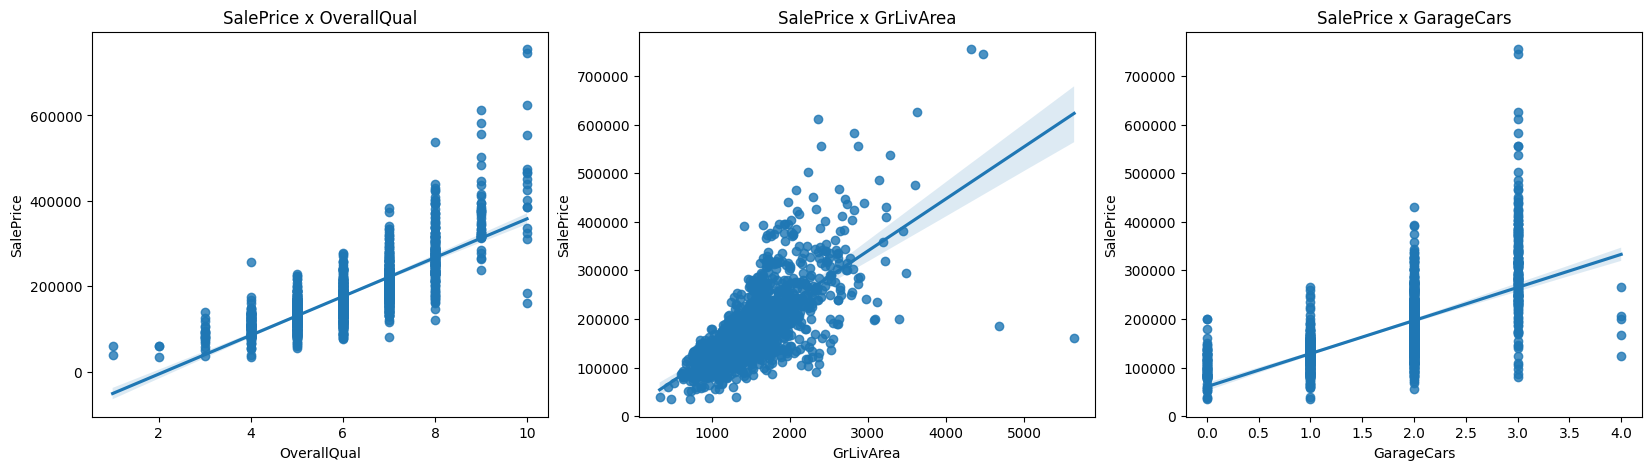

In [216]:
ncols = 3
fig, axs = plt.subplots(ncols=ncols, figsize=(20,5), )
for col, ax in zip(cols_above_thresh.drop('SalePrice')[:ncols], axs):
    sns.regplot(train, x=col, y='SalePrice', ax=ax, ci=95)
    ax.set(title=f'SalePrice x {col}')

We can also see if those features are correlated to each other. Since **highly correlated features usually tells the "same" information to the model**. In this case, the model will give more importance to those features, when it shouldn't.

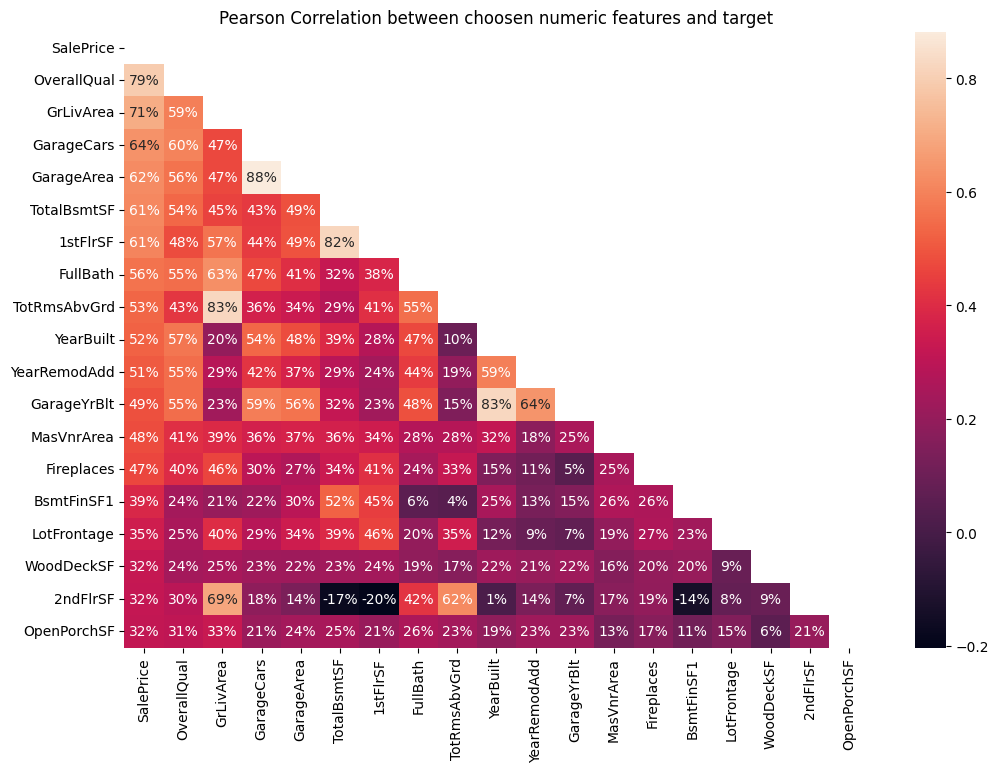

In [217]:
# checking highly correlated numerical features with the heatmap
fig, ax = plt.subplots(figsize=(12,8))
corr = train[cols_above_thresh].corr()
sns.heatmap(corr, ax=ax, mask=np.triu(corr), annot=True, fmt='.0%')
ax.set(title='Pearson Correlation between choosen numeric features and target');

We can see that many features are highly correlated with others, inspecting the data description txt file we can see that:

1. GarageArea (size of garage in square feet) and GarageCars (size of garage in car capacity) have a high correlation (88%) and they **measure the same thing** (size of the garage). We will **remove the GaragaCars** feature since it's **not a standardized way of measuring space** as it's squared feets.

2. 1stFlrSF (1st floor square feet) and TotalBsmtSF (basement square feet) also have high correlation (82%). In this case, they don't measure the same thing, but their correlation is high because **most basements have the same (or similar) size of the house**. We will **drop TotalBsmtSF because not all houses will have a basement**, but all houses will have a first floor I suppose 🤔.

3. GarageYrBlt (year garage was built) and YearBuilt (year of construction of the house) also have high correlation (83%). We can **drop the GarageYrBlt since it has a smaller correlation with the SalePrice** column and because not all houses have a garage, but it's (or should be) necessary for the house to have a construciton date.

4. 2ndFlrSF (second floor square feet) and GrLivArea (living area above ground square feet) have high correlation (69%). We will keep GrLivArea because the correlation with the target SalePrice is higher.

5. We will also remove TotRmsAbvGrd (total rooms above ground excluding bathrooms) because it has a high correlation with GrLivArea (83%). We keep the GrLivArea because, compared to TotRmsAbvGrd, the correlation with the target column SalePrice is higher.

6. Let's also remove FullBath (full bathrooms above ground) because it has high correlation with GrLivArea a (63%).

In [218]:
# adding the columns explained above to the list of columns to drop
columns_to_drop.append(['GarageCars', 'TotalBsmtSF', 'GarageYrBlt', '2ndFlrSF', 'TotRmsAbvGrd', 'FullBath'])

In [219]:
# this is used to flatten the list that contains the columns to drop from the database
columns_to_drop = functools.reduce(operator.iconcat, columns_to_drop, [])

In [220]:
# from those columns with crrelation with the SalePrice higher than the threshold, keep only the ones not in the columns to drop list
numeric_cols_keep = [col for col in cols_above_thresh if col not in columns_to_drop]

## Categorical columns

We can see what is the relationship between each categorical column with the SalePrice by performing ANOVA or Kruskal-Wallis test.

To perform ANOVA, we need to check if each SalePrice sample of each value in each column is normally distributed (we'll check that with the Kolmogorov-Smirnov 🍸 test. If at least one sample is not normally distributed, we'll perform Kruskal-Wallis test because it doesn't need these samples to be normally distributed.

The pseudo-code can be read below:

* For each categorical column:
    * For each value in the column
        * Check the normality of the SalePrice
    * If at least one is not normal, test relation with Kruskal-Wallis
    * If all are normal, test relation using ANOVA

The loop results in a table with categorical column, test used (Kruskal or ANOVA) and pvalue per row. The table can be seen [here](#dfTest).


In [221]:
alpha_test=0.01
alpha_values=0.05

relation_with_SalePrice = pd.DataFrame(columns=['Column','Test', 'Pvalue'])

for col in categorical_cols:
    print(col)
    pvalues = []
    samples = []
    values = train[col].unique()
    values = pd.Series([item for item in values if not isinstance(item, float)])
    nulls = 0
    print(values.values)
    for value in values:
        value_mapping = train.loc[:, col] == value
        sample = train.loc[value_mapping, 'SalePrice']
        if sample.shape[0] < 2 or value==np.nan:
            print(f'no sample for value {value} and column {col}')
            pvalues.append(1)
            continue
        samples.append(sample)
        sample_mean = np.mean(sample)
        sample_std = np.std(sample)
        result = stats.kstest(sample, 'norm', args=(sample_mean, sample_std))
        pvalues.append(result.pvalue)
    if any(x <= alpha_values for x in pvalues) and (len(pvalues) == len(values)) and (len(samples) > 1):
        mapping = [x <= alpha_values for x in pvalues]
        print(f'SalePrice {" ".join(values[mapping])} values from {col} not normally distributed, performing Kruskall-Wallis for {col}')
        _, pvalue = stats.kruskal(*samples)
        decision_text = 'no relation with SalePrice' if pvalue > alpha_test else 'relation with SalePrice'
        print(f'Kruskal-Wallis for {col} pvalue is {pvalue}: {decision_text}')
        relation_with_SalePrice.loc[relation_with_SalePrice.shape[0]] = [col, 'Kruskal-Wallis', pvalue]
    if all(x > alpha_values for x in pvalues) and len(pvalues)==len(values):
        print(f'All categories of {col} are normally distributed. Performing ANOVA.')
        _, pvalue = stats.f_oneway(*samples)
        decision_text = 'no relation with SalePrice' if pvalue > alpha_test else 'relation with SalePrice'
        print(f'ANOVA for {col} pvalue is {pvalue}: {decision_text}')
        relation_with_SalePrice.loc[relation_with_SalePrice.shape[0]] = [col, 'ANOVA', pvalue]

    pvalues.clear()
    samples.clear()
    print('\n')

MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH']
SalePrice RL RM values from MSZoning not normally distributed, performing Kruskall-Wallis for MSZoning
Kruskal-Wallis for MSZoning pvalue is 3.0807239995999556e-57: relation with SalePrice


Street
['Pave' 'Grvl']
SalePrice Pave values from Street not normally distributed, performing Kruskall-Wallis for Street
Kruskal-Wallis for Street pvalue is 0.08012555757743882: no relation with SalePrice


Alley
['Grvl' 'Pave']
All categories of Alley are normally distributed. Performing ANOVA.
ANOVA for Alley pvalue is 4.899826166771113e-08: relation with SalePrice


LotShape
['Reg' 'IR1' 'IR2' 'IR3']
SalePrice Reg IR1 IR2 values from LotShape not normally distributed, performing Kruskall-Wallis for LotShape
Kruskal-Wallis for LotShape pvalue is 1.6403232738441862e-32: relation with SalePrice


LandContour
['Lvl' 'Bnk' 'Low' 'HLS']
SalePrice Lvl values from LandContour not normally distributed, performing Kruskall-Wallis for LandContour
Kruskal-Wallis for 

<a name="dfTest"></a>
This table below contains the pvalue of each column with the SalePrice.It can be used to check the test used (Kruskal-Wallis or ANOVA) and the pvalue of that test with respect to the SalePrice.

This table can be filtered to get all categorical columns that are related to the SalePrice based on the pvalue of the test of that column.

For example, if we use a threshold of 0.01, we're saying that all columns with pvalue smaller than 0.01 have a relationship with the SalePrice.

We can also sort this table by pvalue to get the columns with the smallest pvalues, these are the columns where the sample distributions within the categorical column varies the most

In [222]:
# first 5 rows of the pvalue table
relation_with_SalePrice.head(5)

,Column,Test,Pvalue
0,MSZoning,Kruskal-Wallis,3.080724e-57
1,Street,Kruskal-Wallis,8.012556e-02
2,Alley,ANOVA,4.899826e-08
3,LotShape,Kruskal-Wallis,1.640323e-32
4,LandContour,Kruskal-Wallis,1.047923e-07


In [223]:
# sorting the pvalue table and getting the 5 columns with smallest pvalues (the smaller the pvalue the stronger the correlation with SalePrice)
strongest_related_columns = relation_with_SalePrice.loc[relation_with_SalePrice.Pvalue < 0.01, ].sort_values(by='Pvalue', ascending=True)[:5]
strongest_related_columns

,Column,Test,Pvalue
7,Neighborhood,Kruskal-Wallis,6.696799e-168
17,ExterQual,Kruskal-Wallis,8.180798e-148
29,KitchenQual,Kruskal-Wallis,4.720113e-143
20,BsmtQual,Kruskal-Wallis,1.265030e-136
33,GarageFinish,Kruskal-Wallis,1.974775e-110


In [224]:
categorical_columns_to_keep = list(strongest_related_columns.Column)

# Keeping the choosen columns and filling the train and test datasets

In [225]:
# joining the numerical columns and the categorical columns into a list
cols_to_keep = numeric_cols_keep + categorical_columns_to_keep

In [226]:
# keeping only choosen columns
train = train[cols_to_keep]
test_cols = list(train.columns.drop('SalePrice'))
test_cols.append('Id')
test = test[test_cols]

In [227]:
print(train.shape)
print(test.shape)

(1460, 18)
(1459, 18)


## Filling the train dataset

In [228]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SalePrice     1460 non-null   int64  
 1   OverallQual   1460 non-null   int64  
 2   GrLivArea     1460 non-null   int64  
 3   GarageArea    1460 non-null   int64  
 4   1stFlrSF      1460 non-null   int64  
 5   YearBuilt     1460 non-null   int64  
 6   YearRemodAdd  1460 non-null   int64  
 7   MasVnrArea    1452 non-null   float64
 8   Fireplaces    1460 non-null   int64  
 9   BsmtFinSF1    1460 non-null   int64  
 10  LotFrontage   1201 non-null   float64
 11  WoodDeckSF    1460 non-null   int64  
 12  OpenPorchSF   1460 non-null   int64  
 13  Neighborhood  1460 non-null   object 
 14  ExterQual     1460 non-null   object 
 15  KitchenQual   1460 non-null   object 
 16  BsmtQual      1423 non-null   object 
 17  GarageFinish  1379 non-null   object 
dtypes: float64(2), int64(11), ob

In [229]:
train.isnull().sum().sort_values(ascending=False)

LotFrontage     259
GarageFinish     81
BsmtQual         37
MasVnrArea        8
KitchenQual       0
ExterQual         0
Neighborhood      0
OpenPorchSF       0
WoodDeckSF        0
SalePrice         0
OverallQual       0
Fireplaces        0
YearRemodAdd      0
YearBuilt         0
1stFlrSF          0
GarageArea        0
GrLivArea         0
BsmtFinSF1        0
dtype: int64

Things to take notes:

We should have done the data preparation in the beginning with a better data analysis to understand why some columns contains null values and how to deal with them. But as I already kind of skipped that part 😶 I will procede with the data description provided in the competiton and filling columns with means and modes.

* LotFrontage (linear feet of stree connected to property) is nulll at some houses, but should be at least at a small distance from the street I guess. I'll fill it with the mean or the mode, depending on the dispersion of the feature.

* GarageFinish (interior finish of the garage) is null when there is no garage, we can fill nulls with 'NoGarage' option to pass to the model later

* BsmtQual (evaluate the height of the basement) is null when the house has no basement. We can fill nulls in this case with 'NoBsmt' too.

* MasVnrArea (masonry veneer area in square feet). I'll just fill with the mode or mean again.

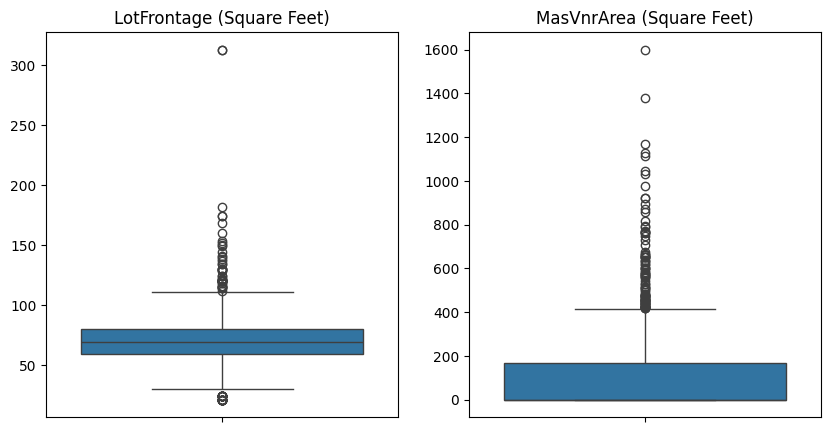

In [230]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

sns.boxplot(train.LotFrontage, ax=ax[0])
sns.boxplot(train.MasVnrArea, ax=ax[1])

ax[0].set(title='LotFrontage (Square Feet)', ylabel='');
ax[1].set(title='MasVnrArea (Square Feet)', ylabel='');

There are many outliers in the LotFrontage and the MasVnrArea, so I guess it's better to fill null values with the median in these case.

In [231]:
# filling the LotFrontage with the median
train.loc[train.LotFrontage.isnull(), 'LotFrontage'] = train.LotFrontage.median()

In [232]:
# filling the MasVnrArea with the median
train.loc[train.MasVnrArea.isnull(), 'MasVnrArea'] = train.MasVnrArea.median()

In [233]:
# filling the GarageFinish with 'NoGarage'
train.loc[train.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'

In [234]:
# filling the BsmtQual with 'NoBsmt'
train.loc[train.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'

In [235]:
train.isnull().sum()

SalePrice       0
OverallQual     0
GrLivArea       0
GarageArea      0
1stFlrSF        0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
Fireplaces      0
BsmtFinSF1      0
LotFrontage     0
WoodDeckSF      0
OpenPorchSF     0
Neighborhood    0
ExterQual       0
KitchenQual     0
BsmtQual        0
GarageFinish    0
dtype: int64

## Filing the test dataset

In this case, we need to use the train dataset features to fill null values from the test dataset.

We can see basically the same features having null values. Except for KitchenQual and BSmtFinSF1 and GarageArea, but they wont make mutch difference because it's only one observation row for each

In [236]:
test.isnull().sum().sort_values(ascending=False)

LotFrontage     227
GarageFinish     78
BsmtQual         44
MasVnrArea       15
GarageArea        1
KitchenQual       1
BsmtFinSF1        1
OpenPorchSF       0
ExterQual         0
Neighborhood      0
OverallQual       0
WoodDeckSF        0
GrLivArea         0
Fireplaces        0
YearRemodAdd      0
YearBuilt         0
1stFlrSF          0
Id                0
dtype: int64

In [237]:
# filling the LotFrontage with the median
test.loc[test.LotFrontage.isnull(), 'LotFrontage'] = train.LotFrontage.median()

# filling the MasVnrArea with the median
test.loc[test.MasVnrArea.isnull(), 'MasVnrArea'] = train.MasVnrArea.median()

# filling the GarageFinish with 'NoGarage'
test.loc[test.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'

# filling the BsmtQual with 'NoBsmt'
test.loc[test.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'

Looking the features KitchenQual, BsmtFinSF1 and GarageArea

* KitchenQual is the quality of the kitchen, will fill with the mode, as all houses should have a kitchen so this is probably an error in the database

* BsmtFinSF1 is the Type 1 finished square feet. Null values means no basement, so 0 square feet.

* GarageArea: Size of garage in square feet. It does'nt say anything about null values, and as common sense not all houses have garages. But looking at the GarageFinish feature, where it says that null values means no garage, them this row/house specifically has no garage, so we can fill this row with 0.

In [238]:
# filling the KitchenQual feature in the test dataset qith the mode from the train dataset
test.loc[test.KitchenQual.isnull(), 'KitchenQual'] = train.KitchenQual.mode()[0]

In [239]:
# filling the BsmtFinSF1 with 0 since null values means there is no basement according to description
test.loc[test.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = 0

In [240]:
# Garage Area in this case row seems to have no garage because GarageFinish was null when there was no garage and we filled this information accordingly
test.loc[test.GarageArea.isnull(), ['GarageArea','GarageFinish']].value_counts(dropna=False)

GarageArea  GarageFinish
NaN         NoGarage        1
Name: count, dtype: int64

In [241]:
# filling the GarageArea for the test set with value 0
test.loc[test.GarageArea.isnull(), 'GarageArea'] = 0

In [242]:
test.isnull().sum().sort_values(ascending=False)

OverallQual     0
GrLivArea       0
GarageFinish    0
BsmtQual        0
KitchenQual     0
ExterQual       0
Neighborhood    0
OpenPorchSF     0
WoodDeckSF      0
LotFrontage     0
BsmtFinSF1      0
Fireplaces      0
MasVnrArea      0
YearRemodAdd    0
YearBuilt       0
1stFlrSF        0
GarageArea      0
Id              0
dtype: int64

# Transforming text data


We need to transform text data to numbers becase the models can't understand it as text, it cannot perform computation with text, just numbers. For that, we can use one hot encoder or ordinal encoder, depending if the categorical variable/feature is ordinal or nominal.

In the cleaned database we have 5 categorical features: 1 nominal and 4 are ordinal. The feature Neighborhood is nominal and ExterQual, KitchenQual, BsmtQual and GarageFinish are all ordinal. We will use one hot encoding for Neighborhood and ordinal encoding for the rest.

In [243]:
train.dtypes

SalePrice         int64
OverallQual       int64
GrLivArea         int64
GarageArea        int64
1stFlrSF          int64
YearBuilt         int64
YearRemodAdd      int64
MasVnrArea      float64
Fireplaces        int64
BsmtFinSF1        int64
LotFrontage     float64
WoodDeckSF        int64
OpenPorchSF       int64
Neighborhood     object
ExterQual        object
KitchenQual      object
BsmtQual         object
GarageFinish     object
dtype: object

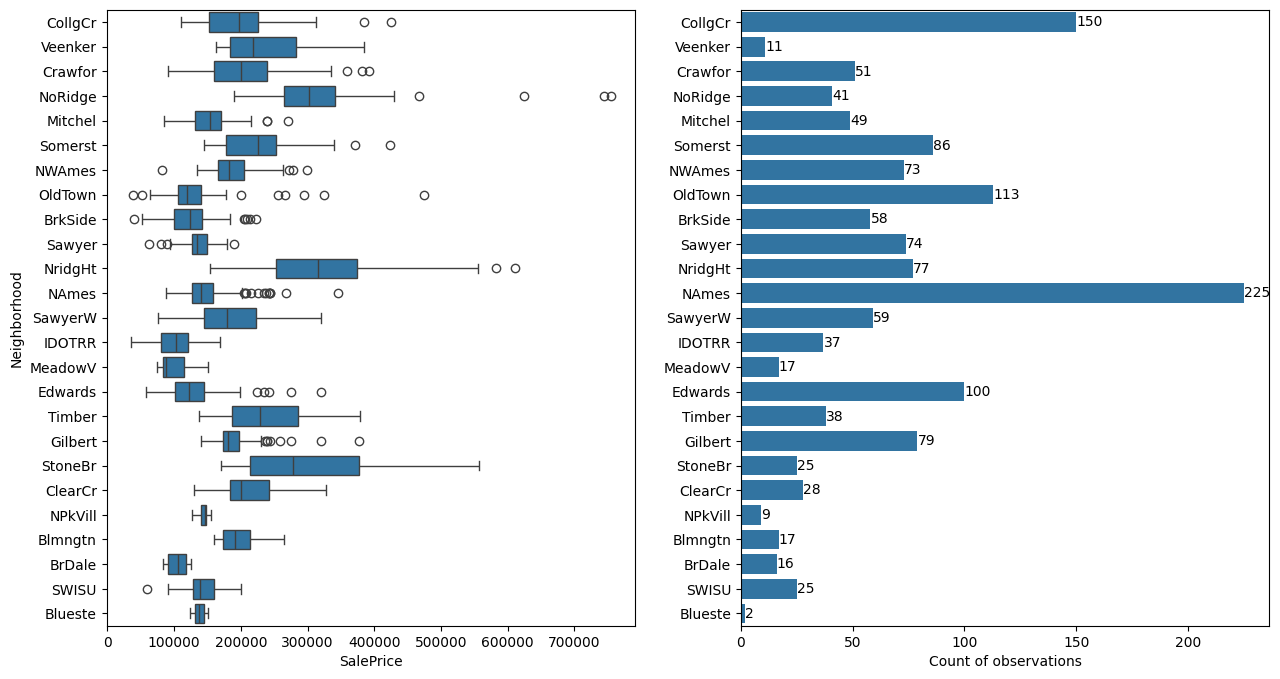

In [244]:
fig, ax = plt.subplots(figsize=(15,8), ncols=2)

sns.boxplot(x=train.SalePrice, y=train.Neighborhood, ax=ax[0])
sns.barplot(x=train.SalePrice, y=train.Neighborhood, ax=ax[1], estimator='size')
ax[1].bar_label(ax[1].containers[0], label_type='edge')
ax[1].set(ylabel='', xlabel='Count of observations');

One hot encoding is used to expres categorical values in numerical form that can be passed to the model. It creates a column for each value in the categorical column and assign 1 or 0 depending on the categorical column value. For example, the value of the first row is Red, so we assign 1 for the Encoded Red column and 0 for the other columns.

| Original Color | Encoded Red | Encoded Green | Encoded Blue |
|----------------|-------------|---------------|--------------|
| Red            | 1           | 0             | 0            |
| Green          | 0           | 1             | 0            |
| Blue           | 0           | 0             | 1            |


Since we have many possible values under Neighborhood, we can pass a parameter that will handle infrequent values by assigning them to the same column, so we don't end up with too much columns. For example, from the code below, we can see that the 15% of properties are in NAmes (North Ames), 10% are in CollgCr (College Creek), etc. We can say that classes with less than 5% observation will be gathered to an infrequent column.

In [245]:
train.groupby('Neighborhood').SalePrice.count().sort_values(ascending=False)/train.shape[0]

Neighborhood
NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    0.028082
Timber     0.026027
IDOTRR     0.025342
ClearCr    0.019178
StoneBr    0.017123
SWISU      0.017123
Blmngtn    0.011644
MeadowV    0.011644
BrDale     0.010959
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: SalePrice, dtype: float64

In [246]:
# creating the one hot encoder and fitting it to the train data
ohe = OneHotEncoder(dtype=np.int64, handle_unknown='infrequent_if_exist', min_frequency=0.05, sparse_output=False)
ohe.fit(train[['Neighborhood']])
train = pd.concat(
    [
        train,
        pd.DataFrame(ohe.transform(train[['Neighborhood']]), columns=ohe.get_feature_names_out())
    ],
    axis=1
)
train = train.drop('Neighborhood', axis=1)

In [247]:
train.loc[:, train.columns.str.contains('Neighborhood')].head(5)

,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_infrequent_sklearn
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1


In [248]:
# using the one hot encoder to transform the data in the test set
test = pd.concat(
    [
        test,
        pd.DataFrame(ohe.transform(test[['Neighborhood']]), columns=ohe.get_feature_names_out())
    ],
    axis=1
)
test = test.drop('Neighborhood', axis=1)

In [249]:
test.loc[:, test.columns.str.contains('Neighborhood')].head(5)

,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_infrequent_sklearn
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1


Now using the ordinal encoder to transform text data to ordinal values. This will be done for the following columns:

* ExterQual  
* KitchenQual
* BsmtQual   
* GarageFinish

The ordinal encoder will basically map the value in the column to a number based on the order of that value. For example, if we have 3 values: Poor, Average and Excellent, Poor will be associated with 0, Average with 1 and Excellent with 2. It's necessary to tell the encoder the order of numerical values, for example, first value associates with 0, second value associates with 1, etc.

In the ExterQual feature, we need to pass the list as:

```
['Po', 'Fa', 'TA', 'Gd', 'Ex']
```
because it is the order of quality of the external materials and it will be mapped to this

```
['Po', 'Fa', 'TA', 'Gd', 'Ex'] -> [0, 1, 2, 3, 4]
```


In [250]:
# calculating the percentage of observations for each value of each categorical column
for col in train.columns[train.dtypes == 'object']:
    print(train[col].value_counts()/train.shape[0])

ExterQual
TA    0.620548
Gd    0.334247
Ex    0.035616
Fa    0.009589
Name: count, dtype: float64
KitchenQual
TA    0.503425
Gd    0.401370
Ex    0.068493
Fa    0.026712
Name: count, dtype: float64
BsmtQual
TA        0.444521
Gd        0.423288
Ex        0.082877
NoBsmt    0.025342
Fa        0.023973
Name: count, dtype: float64
GarageFinish
Unf         0.414384
RFn         0.289041
Fin         0.241096
NoGarage    0.055479
Name: count, dtype: float64


In [251]:
# mapping values from each categorical column to a numeric value
mapping = [
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'], # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'], # KitchenQual
    ['NoBsmt', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # BsmtQual: passing NoBsmt first means that not having basement is worse than having a poor basement
    ['NoGarage', 'Unf', 'RFn', 'Fin'] # GarageFinish: passing NoGarage first means that not having garage is worse than having a unifished garage
]

In [252]:
# creating the ordinal encoder and fitting the train data
oe = OrdinalEncoder(categories=mapping, dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
oe.fit(train[['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish']])
train[['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish']] = oe.transform(train[['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish']])

In [253]:
train[['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish']].head(5)

,ExterQual,KitchenQual,BsmtQual,GarageFinish
0,3,3,4,2
1,2,2,4,2
2,3,3,4,2
3,2,3,3,1
4,3,3,4,2


In [254]:
# using the ordinal encoder to transform the data in the test set
test[['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish']] = oe.transform(test[['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish']])

In [255]:
test[['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish']].head(5)

,ExterQual,KitchenQual,BsmtQual,GarageFinish
0,2,2,3,1
1,2,3,3,1
2,2,2,4,3
3,2,3,3,3
4,3,3,4,2


# All data was cleaned, time to check the models (the best part) 😀 🚀

In this part, we will:

1. Split the train data in two parts. One to efectively train the data and the other to validate the best model.

2. Take the best model and do a grid search to tune hyperparameters.

3. Submit the predictions of the test set to the Kaggle competition.

In [53]:
# splitting the train data into new train and validation datasets
x = train.drop('SalePrice', axis=1)
y = train.SalePrice
x_new_train, x_val, y_new_train, y_val = train_test_split(x, y, random_state=0, test_size=0.25)

In [54]:
print(f'rows in new train data: {y_new_train.shape[0]}')
print(f'rows in validation data: {y_val.shape[0]}')

rows in new train data: 1095
rows in validation data: 365


The kaggle competition will evaluate the best model based on the root-mean-squared-error of the logarithm of the predictions and observed SalePrice, because log will compress the range of the SalePrice observed and predicted values, returning a metric that will be less impacted by expensive and cheap houses. The formula to the error can be seen below.

\begin{align*}
\text{RMSE} &= \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(\hat{y}_i) - \log(y_i))^2}
\end{align*}

where $\hat{y}_i$ is the predicted value and $y_i$ is the trume value of the SalePrice.

In [59]:
log_y_val = np.log(y_val)

In [61]:
# fitting the linear regression model, taking the log of the predictions and using the RMSE with the log of the observed SalePrice
lr = LinearRegression().fit(x_new_train, y_new_train)
lr_log_pred_y_val = np.log(lr.predict(x_val))
lr_log_rmse = root_mean_squared_error(log_y_val, lr_log_pred_y_val)

In [62]:
# fitting the gradient boosting regressor model, taking the log of the predictions and using the RMSE with the log of the observed SalePrice
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(x_new_train, y_new_train)
gbr_lof_pred_y_val = np.log(gbr.predict(x_val))
gbr_log_rmse = root_mean_squared_error(log_y_val, gbr_lof_pred_y_val)

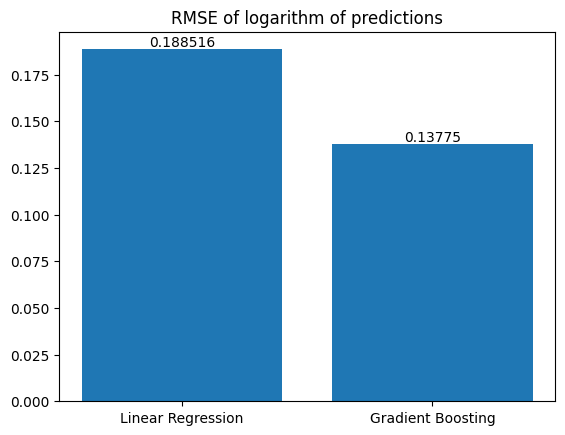

In [69]:
# comparing predictions
fig, ax = plt.subplots()

ax.bar(x=['Linear Regression', 'Gradient Boosting'], height=[lr_log_rmse, gbr_log_rmse])

ax.bar_label(ax.containers[0], label_type='edge')

ax.set(title='RMSE of logarithm of predictions');

As can be seen in the bar chart above, the Gradient Boosting model had a better performance since the RMSE of the log of predictions were smaller than for the linear regression model.

We wil continue with this model for the hypermarameter tuning using grid search. We will fit the model again trying the following hyperparameters and validating it with a 5 cross validation strategy and the RSME of log of predictions.

Hyperparameters:

* Learning rate: 0.001, 0.01 and 0.1

* n_estimators: 10, 100, 1000 and 10000

* criterion: friedman_mse and squared_error


We also need to build the scorer function since the RMSE of the log of predictions is not a standartd scorer function in scikit learn. As per documentation, since I'm creating a loss function and not a score function, the sign will flip, so we'll see negative results.

In [78]:
# building the scorer function
def rmse_of_log(y_true, y_pred):
    """
    This scorer function will calcualte the RMSE of the log of predictions and true values
    """
    return root_mean_squared_error(np.log1p(y_true), np.log1p(y_pred))
rmse_log_scorer= make_scorer(rmse_of_log, greater_is_better=False)

In [84]:
# using gridsearch with the gradient boosting model.
parameters = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [10, 100, 1000, 10000],
    'criterion': ['friedman_mse', 'squared_error']
}
gbr = GradientBoostingRegressor(random_state=42)
clf = GridSearchCV(estimator=gbr, param_grid=parameters, scoring=rmse_log_scorer, n_jobs=-1, cv=5, verbose=3)
clf.fit(x, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [10, 100, 1000, 10000]},
             scoring=make_scorer(rmse_of_log, greater_is_better=False, response_method='predict'),
             verbose=3)

In [102]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score', ascending=True)[['rank_test_score', 'mean_test_score', 'std_test_score', 'params']].head(5)

,rank_test_score,mean_test_score,std_test_score,params
15,1,-0.143493,0.009702,"{'criterion': 'squared_error', 'learning_rate'..."
3,2,-0.143494,0.009703,"{'criterion': 'friedman_mse', 'learning_rate':..."
18,3,-0.143621,0.009640,"{'criterion': 'squared_error', 'learning_rate'..."
6,3,-0.143621,0.009640,"{'criterion': 'friedman_mse', 'learning_rate':..."
21,5,-0.145161,0.009237,"{'criterion': 'squared_error', 'learning_rate'..."


In [89]:
# printing the best score of the model
clf.best_score_

-0.1434927793388759

In [87]:
# print best parameters found on the grid search
clf.best_params_

{'criterion': 'squared_error', 'learning_rate': 0.001, 'n_estimators': 10000}

In [90]:
# best estimator using the grid search
clf.best_estimator_

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.001,
                          n_estimators=10000, random_state=42)

Persisting the best estimator using joblib.

In [94]:
joblib.dump(clf.best_estimator_, 'gbr.pkl')

['gbr.pkl']

# Submitting result to Kaggle competition

In [107]:
# loading the saved gradient boosting estimator
saved_regressor = joblib.load('gbr.pkl')

In [171]:
# predicting in the test dataset
test_pred = saved_regressor.predict(test)

In [256]:
test.columns

Index(['OverallQual', 'GrLivArea', 'GarageArea', '1stFlrSF', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage',
       'WoodDeckSF', 'OpenPorchSF', 'ExterQual', 'KitchenQual', 'BsmtQual',
       'GarageFinish', 'Id', 'Neighborhood_CollgCr', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Sawyer',
       'Neighborhood_Somerst', 'Neighborhood_infrequent_sklearn'],
      dtype='object')

In [258]:
test_predictions = pd.DataFrame(
    {
        'Id': test.Id,
        'SalePrice': test_pred
    }
)
test_predictions.head(5)

,Id,SalePrice
0,1461,131529.270753
1,1462,146013.026711
2,1463,176791.608203
3,1464,183016.665005
4,1465,200628.030050


In [259]:
test_predictions.to_csv('gradient_boosting_regressor_predictions.csv', index=False)

In [261]:
# create the .kaggle directory
!mkdir -p ~/.kaggle

In [263]:
# copy the kaggle.json file to thehis kaggle directory
!cp kaggle.json ~/.kaggle/

In [265]:
# change permission to kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [266]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f /content/gradient_boosting_regressor_predictions.csv -m "Gradient Boosting Regressor model, using Pearson correlation, ANOVA and Kruskal-Wallis for feature decision and grid search for tuning hyperparameters"

100% 33.7k/33.7k [00:00<00:00, 59.1kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques